In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [2]:
%load_ext autoreload
%autoreload 2
from lib import wrap_labels, adjust_pairplot_axes

# OTP Overconcentration

The data below is essentially the same as the GHC website's "oversaturation data", except:
* I don't drop patient zip codes outside NYC, which I believe fell through a join somewhere


My goal is to make the "OTP programs are overconcentrated in Harlem" in a bunch of ways:
* Harlem Admission % ~ Harlem Capacity % > Harlem Patient % > Harlem population %
    * Compare with other areas of the city
* Compare fractions of admissions residing outside across different districts
    * Across programs?
* Compare with OD rates?

## By District (no patient residences, but I currently have populations)

In [18]:
sql = """
select
    borough_district_code,
    district_population AS "Population", 
    CASE WHEN is_harlem THEN 'Harlem' ELSE 'Rest of NYC' END AS is_harlem,
    total_admissions_3_2017 AS "Estimated OTP Admissions (2017)",
    total_admissions_3_2019 AS "Estimated OTP Admissions (2019)",
    otp_capacity AS "Reported OTP Capacity (2019)",
    avg_daily_enrollment_2019 AS "Reported Daily Avg OTP Enrollment (2019)"
from district_otp_analysis
"""
district_df = pd.read_sql(sql, con=db_url)
district_df = district_df.fillna(0)

for c in [
    'borough_district_code',
    'is_harlem'
]:
    district_df[c] = pd.Categorical(district_df[c])

district_df['Estimated Fraction of OTP Admissions (2019)'] = district_df["Estimated OTP Admissions (2019)"] \
    / district_df["Estimated OTP Admissions (2019)"].sum()
district_df['Fraction of Population'] = district_df["Population"] \
    / district_df["Population"].sum()

district_df = district_df.set_index('borough_district_code')
district_df.head(3).T


borough_district_code,501,309,308
Population,189663,102000,108259
is_harlem,Rest of NYC,Rest of NYC,Rest of NYC
Estimated OTP Admissions (2017),34.0,205.0,280.0
Estimated OTP Admissions (2019),37.0,198.0,210.0
Reported OTP Capacity (2019),220.0,750.0,750.0
Reported Daily Avg OTP Enrollment (2019),218.0,517.0,661.0
Estimated Fraction of OTP Admissions (2019),0.002892,0.015474,0.016411
Fraction of Population,0.039841,0.021426,0.022741


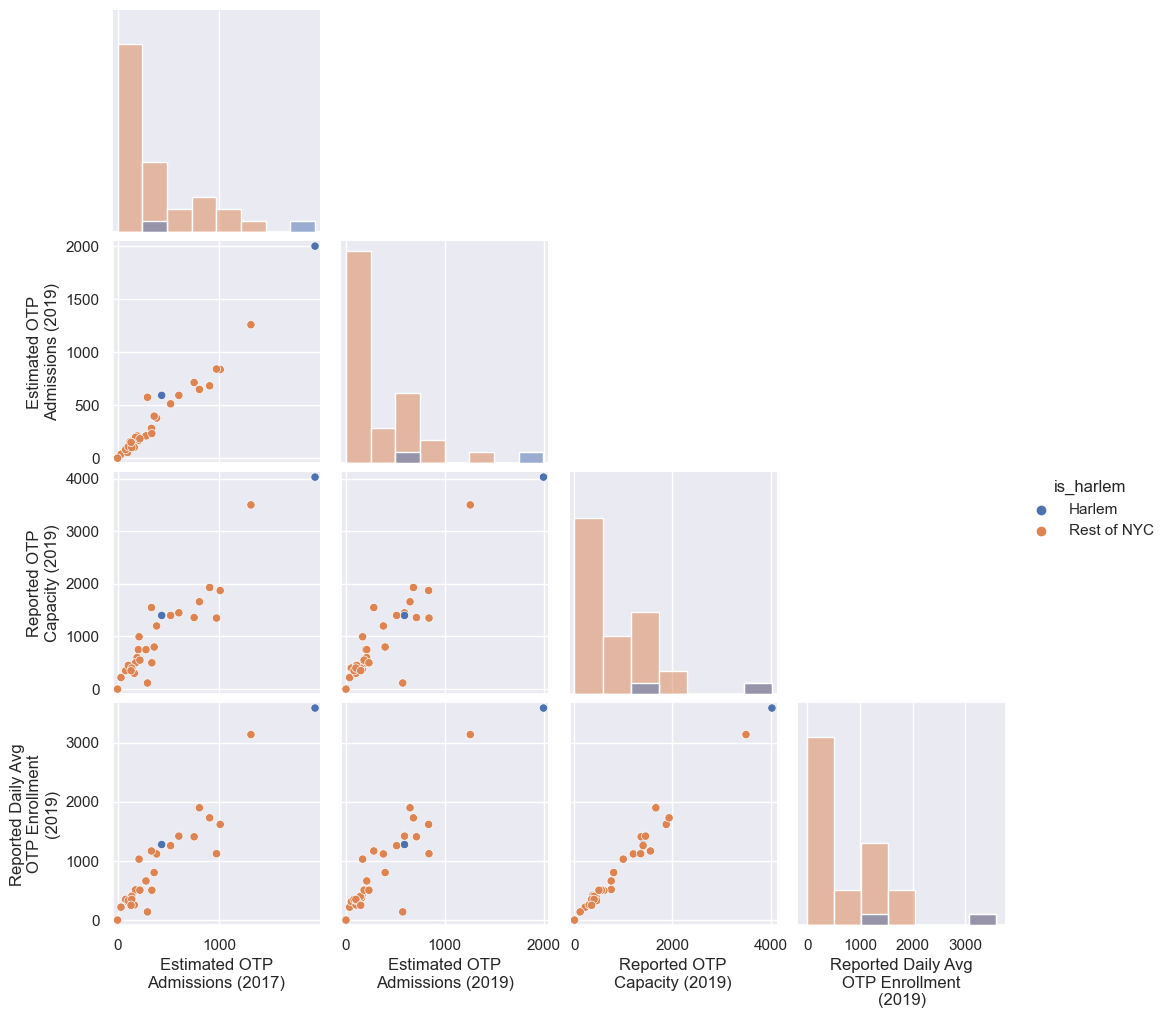

In [19]:
measures = [
    'Estimated OTP Admissions (2017)',
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)'
]

p = seaborn.pairplot(
    district_df[measures + ['is_harlem']], 
    hue='is_harlem',
    diag_kind="hist", 
    corner=True
);

adjust_pairplot_axes(district_df, measures, p)

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
is_harlem,,,,
Harlem,0.05382,0.202485,0.169879,0.166718
Rest of NYC,0.94618,0.797515,0.830121,0.833282


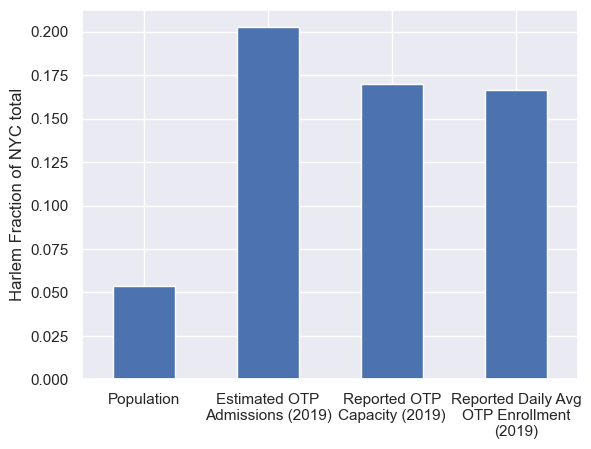

In [20]:
district_metrics_by_harlem = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .groupby(district_df['is_harlem'])
    .sum()
)
district_metrics_by_harlem = district_metrics_by_harlem / district_metrics_by_harlem.sum()
ax = district_metrics_by_harlem.loc['Harlem'].plot(
    kind='bar',
    ylabel='Harlem Fraction of NYC total'
);
plt.xticks(rotation=0)
wrap_labels(ax, 20)
district_metrics_by_harlem

,Population,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019)
borough_district_code,,,,
111,0.100255,0.246395,0.199931,0.193803
201,0.080453,0.155060,0.173680,0.169578
206,0.071116,0.079872,0.082374,0.102633
106,0.124044,0.084063,0.095772,0.093441
103,0.130044,0.103044,0.092944,0.087438
306,0.090819,0.072969,0.071953,0.076732
205,0.105686,0.087884,0.067487,0.076137
110,0.103977,0.072969,0.069472,0.069053
102,0.073690,0.063109,0.069472,0.068026


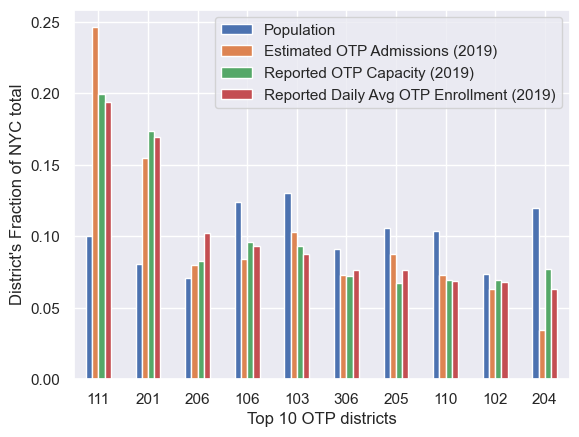

In [21]:
district_metrics_by_district = (
    district_df[[
        'Population',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
    ]]
    .sort_values("Reported Daily Avg OTP Enrollment (2019)", ascending=False)
    .head(10)
)
district_metrics_by_district = district_metrics_by_district / district_metrics_by_district.sum()
district_metrics_by_district.plot(
    kind='bar',
    ylabel="District's Fraction of NYC total",
    xlabel='Top 10 OTP districts'
);
plt.xticks(rotation=0)
district_metrics_by_district

## By Zip Code (includes Patient Residences)

In [22]:
sql = """
select 
    z.zip_code,
    z.neighborhood_name,
    z.borough_name,
    CASE WHEN z.is_harlem THEN 'Harlem' 
        WHEN z.borough_name = 'Manhattan' THEN 'Manhattan (Except Harlem)'
        ELSE z.borough_name END AS is_harlem,
    coalesce(total_admissions_3_2017, 0) AS "Estimated OTP Admissions (2017)",
    coalesce(total_admissions_3_2019, 0) AS "Estimated OTP Admissions (2019)",
    coalesce(otp_capacity, 0) AS "Reported OTP Capacity (2019)",
    coalesce(avg_daily_enrollment_2019, 0) AS "Reported Daily Avg OTP Enrollment (2019)",
    coalesce(patient_admissions_3_2019, 0) AS "Estimated OTP Patient Residents (2019)",
    coalesce(harlem_patient_admissions_3_2019, 0) As "Estimated OTP Patient Residents (Harlem Programs, 2019)",
    coalesce(opioid_burden_2019, 0) AS "Opioid Burden (2019)",
    z.population_total AS "Estimated Population (2020)"
from zip_codes z
    left join zip_code_otp_analysis za on z.zip_code = za.zip_code 
"""
zip_df = pd.read_sql(sql, con=db_url)


zip_df['Estimated OTP Patient Residents (Non-Harlem Programs, 2019)'] = \
    zip_df['Estimated OTP Patient Residents (2019)'] - zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"]
zip_df['Estimated Fraction of OTP Admissions (2019)'] = zip_df["Estimated OTP Admissions (2019)"] \
    / zip_df["Estimated OTP Admissions (2019)"].sum()
zip_df['Estimated Fraction of OTP Patient Residents (2019)'] = zip_df["Estimated OTP Patient Residents (2019)"] \
    / zip_df["Estimated OTP Patient Residents (2019)"].sum()
zip_df['Estimated Fraction of Harlem OTP Patient Residents (2019)'] =  zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"] / \
    zip_df["Estimated OTP Patient Residents (Harlem Programs, 2019)"].sum()
zip_df['Fraction of Opioid Burden (2019)'] =  zip_df["Opioid Burden (2019)"] / \
    zip_df["Opioid Burden (2019)"].sum()

for c in [
    'zip_code',
    'neighborhood_name',
    'borough_name',
    'is_harlem'
]:
    zip_df[c] = pd.Categorical(zip_df[c])

zip_df = zip_df.set_index('zip_code')

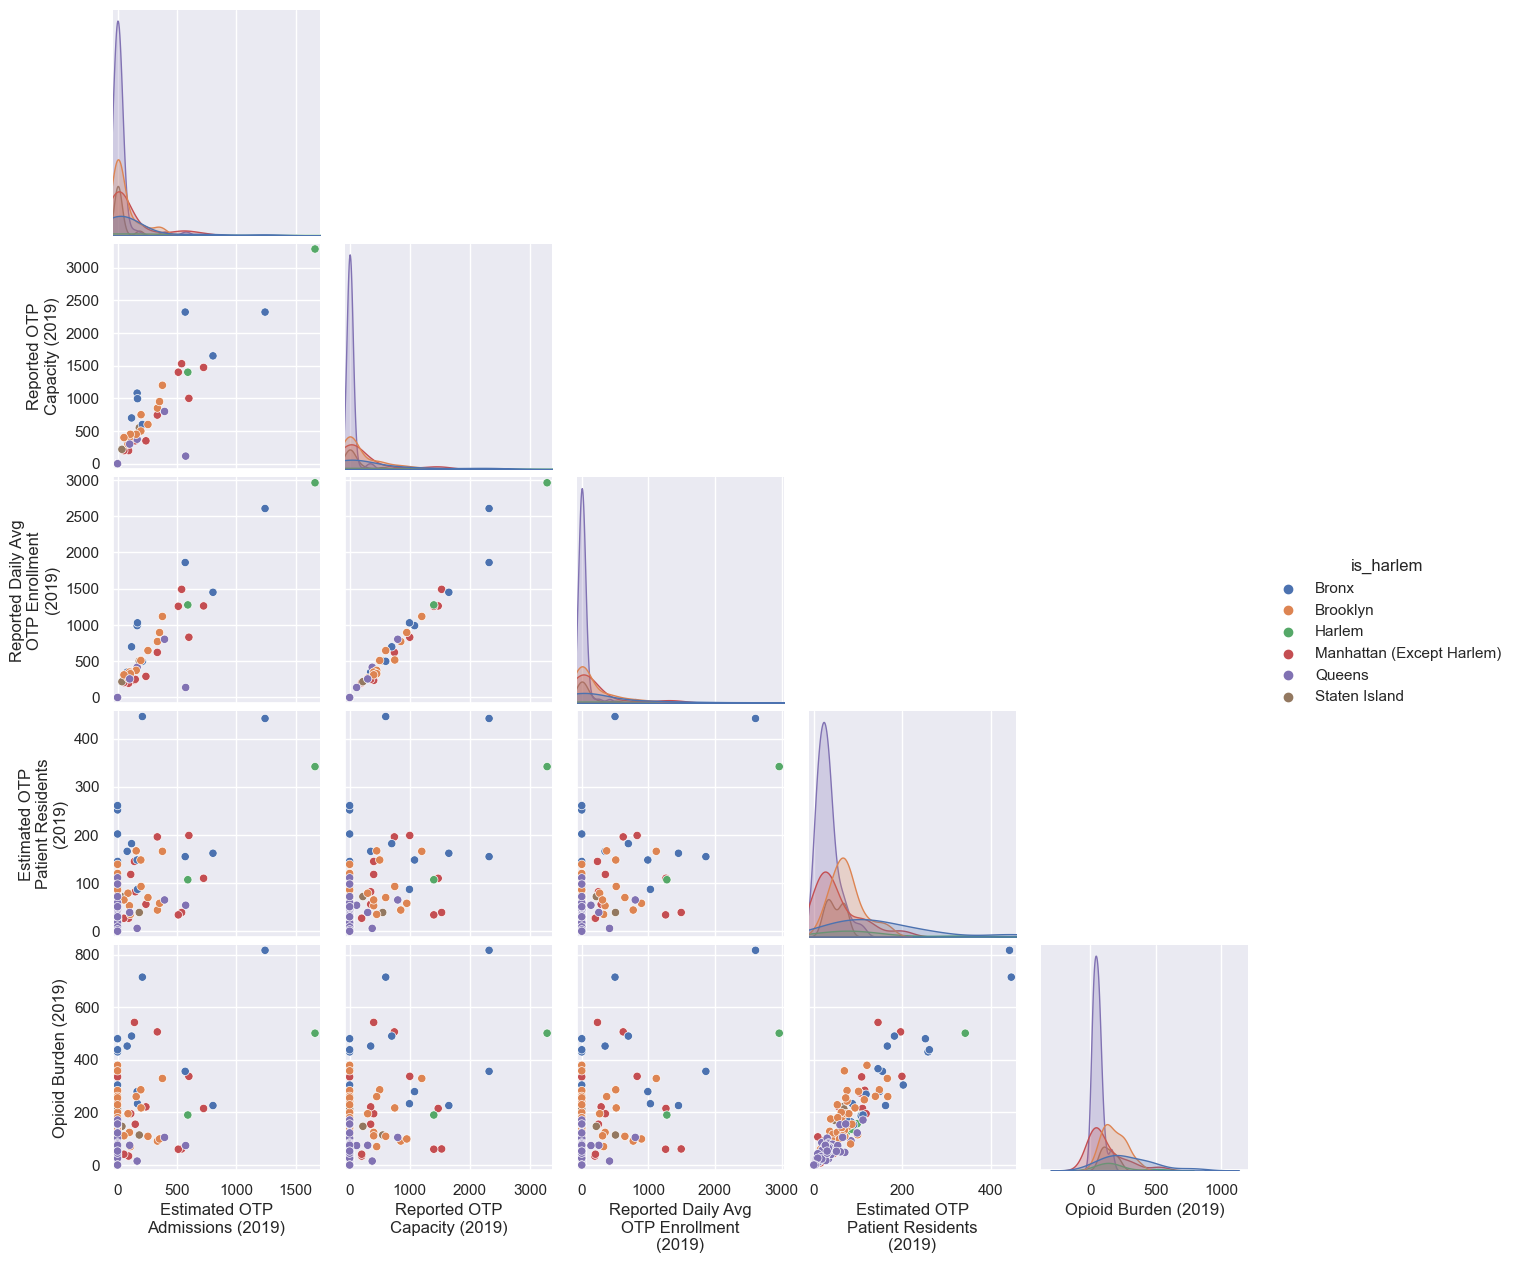

In [23]:
measures = [
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)',
    'Estimated OTP Patient Residents (2019)',
    'Opioid Burden (2019)'
]

p = seaborn.pairplot(
    zip_df[measures + ['is_harlem']], 
    hue='is_harlem',
    corner=True
)
adjust_pairplot_axes(zip_df, measures, p)

In [24]:
def plot_xy_interactive(df, x_col, y_col, color_col, identity_line=True):
    subset = df[[x_col, y_col]]
    subset_max_pct = subset.max().max()
    domain_max = subset_max_pct * 1.05
    scale = altair.Scale(domain=[0, domain_max])

    plot = (altair.Chart(df)
        .properties(height=500, width=500)
        .mark_circle(size=60)
        .encode(
            x=altair.X(x_col, scale=scale),
            y=altair.Y(y_col, scale=scale),
            color=color_col,
            tooltip=list(df.columns)
        )
        .interactive()
    )
    if identity_line:
        line = pd.DataFrame({
            x_col: [0, domain_max],
            y_col: [0, domain_max],
        })
        line_plot = altair.Chart(line)\
            .mark_line(color='gray', strokeDash=[2, 4])\
            .encode(x=x_col, y=y_col)
        return plot + line_plot
    else:
        return plot


In [12]:
plot_xy_interactive(
    zip_df,
    x_col = 'Estimated Fraction of OTP Patient Residents (2019)',
    y_col = 'Estimated Fraction of OTP Admissions (2019)',
    color_col='is_harlem'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [11]:

(altair.Chart(zip_df)
    .properties(height=500, width=500)
    .mark_circle(size=60)
    .encode(
        x='Opioid Burden (2019)',
        y='Reported OTP Capacity (2019)', 
        color='is_harlem',
        tooltip=list(zip_df.columns)
    )
    .interactive()
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


,Estimated OTP Patient Residents (2019),Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019),Fraction of Opioid Burden (2019),Estimated Population (2020)
is_harlem,,,,,,
Bronx,0.245710,0.188968,0.304713,0.273497,0.324240,0.186740
Brooklyn,0.267464,0.217491,0.201086,0.201939,0.270280,0.326304
Harlem,0.069567,0.118148,0.156437,0.137280,0.061833,0.035212
Manhattan (Except Harlem),0.147766,0.262170,0.241724,0.240750,0.182305,0.164062
Queens,0.206404,0.165895,0.069376,0.103846,0.105337,0.235261
Staten Island,0.063089,0.047328,0.026664,0.042689,0.056005,0.052421


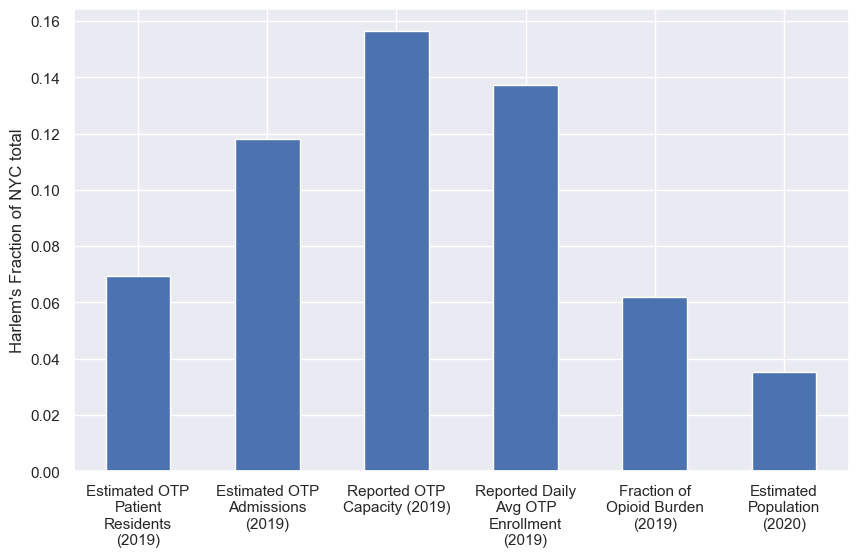

In [13]:
zip_program_metrics = (
    zip_df[[
        'Estimated OTP Patient Residents (2019)',
        'Estimated OTP Admissions (2019)',
        'Reported OTP Capacity (2019)',
        'Reported Daily Avg OTP Enrollment (2019)',
        'Fraction of Opioid Burden (2019)',
        "Estimated Population (2020)"
    ]]
    .groupby(zip_df['is_harlem'])
    .sum()
)

zip_program_metrics = zip_program_metrics / zip_program_metrics.sum()
ax = zip_program_metrics.loc['Harlem'].plot(
    kind='bar',
    ylabel="Harlem's Fraction of NYC total",
    figsize=(10, 6)
)
plt.xticks(rotation=0);
wrap_labels(ax, 15)
zip_program_metrics


,"Estimated OTP Patient Residents (Harlem Programs, 2019)"
is_harlem,
Harlem,0.277955
Manhattan (Except Harlem),0.261981
Bronx,0.247832
Queens,0.107257
Brooklyn,0.093108
Staten Island,0.011867


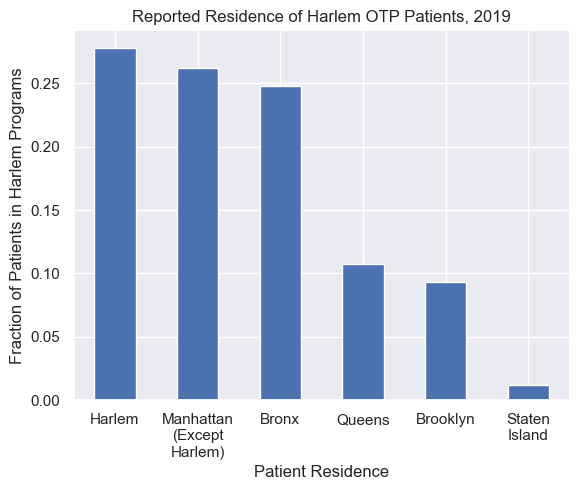

In [14]:
zip_patient_metrics = (
    zip_df[[
        "Estimated OTP Patient Residents (Harlem Programs, 2019)",
    ]]
    .groupby(zip_df['is_harlem'])
    .sum()
)
zip_patient_metrics = zip_patient_metrics / zip_patient_metrics.sum()
zip_patient_metrics = zip_patient_metrics.sort_values("Estimated OTP Patient Residents (Harlem Programs, 2019)", ascending=False)
ax = (zip_patient_metrics
    .plot(
        kind='bar',
        xlabel='Patient Residence',
        ylabel='Fraction of Patients in Harlem Programs',
        legend=False,
        title='Reported Residence of Harlem OTP Patients, 2019'
    )
)
plt.xticks(rotation=0)
wrap_labels(ax, 10)
zip_patient_metrics


In [15]:
x_col = 'Estimated Fraction of OTP Patient Residents (2019)'
y_col = 'Estimated Fraction of Harlem OTP Patient Residents (2019)'
plot_xy_interactive(zip_df, x_col, y_col, 'is_harlem')


<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019),Estimated OTP Patient Residents (2019),Opioid Burden (2019),Estimated Population (2020)
is_harlem,,,,,,
Brooklyn,0.217491,0.201086,0.201939,0.267464,0.270280,0.326304
Bronx,0.188968,0.304713,0.273497,0.245710,0.324240,0.186740
Queens,0.165895,0.069376,0.103846,0.206404,0.105337,0.235261
Manhattan (Except Harlem),0.262170,0.241724,0.240750,0.147766,0.182305,0.164062
Harlem,0.118148,0.156437,0.137280,0.069567,0.061833,0.035212
Staten Island,0.047328,0.026664,0.042689,0.063089,0.056005,0.052421


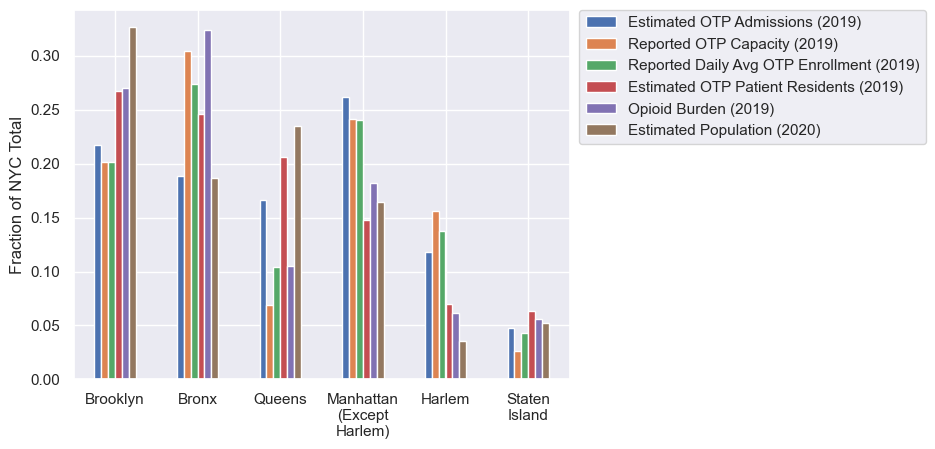

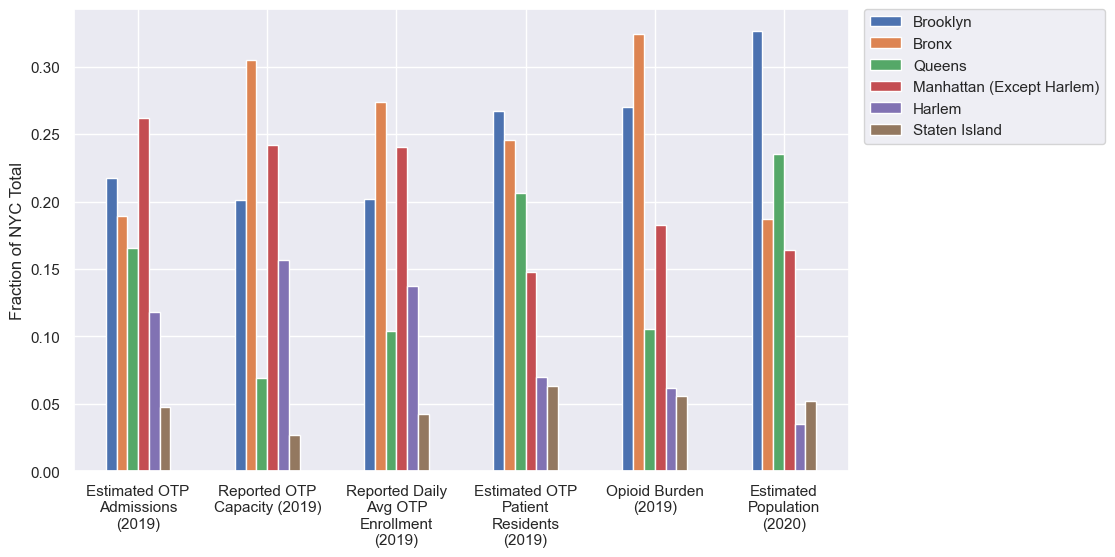

In [16]:
borough_program_metrics = zip_df[[
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)',
    'Estimated OTP Patient Residents (2019)',
    'Opioid Burden (2019)',
    "Estimated Population (2020)"
]].groupby(zip_df['is_harlem']).sum()
borough_program_metrics = borough_program_metrics / borough_program_metrics.sum()
borough_program_metrics = borough_program_metrics.sort_values('Estimated OTP Patient Residents (2019)', ascending=False)
ax = borough_program_metrics.plot(
    kind='bar', 
    xlabel='',
    ylabel='Fraction of NYC Total'
)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
wrap_labels(ax, 10)

# Sort of easier to see pivoted
ax2 = borough_program_metrics.T.plot(
    kind='bar', 
    ylabel='Fraction of NYC Total',
    figsize=(10,6)
)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xticks(rotation=0)
wrap_labels(ax2, 15)

borough_program_metrics